**Table of contents**<a id='toc0_'></a>    
- [Partly for the creation of annotated dataset](#toc1_1_1_1_)    
    - [Count legal type of dataset](#toc1_1_2_)    
    - [Count relation type](#toc1_1_3_)    
    - [Some files with examples of each relation type](#toc1_1_4_)    
    - [Extraction of X, y and save to Ggsheet for annotation](#toc1_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import re
import sys, os

from underthesea import sent_tokenize
import difflib

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from shared_functions.global_functions import *
from shared_functions.gg_sheet import *

#### <a id='toc1_1_1_1_'></a>[Partly for the creation of annotated dataset](#toc0_)

In [10]:
from pyvi import ViTokenizer, ViPosTagger, ViUtils

print(ViTokenizer.tokenize(u"Trường đại học bách khoa hà nội"))

print(ViPosTagger.postagging(ViTokenizer.tokenize(u"Trường đại học Bách Khoa Hà Nội")))

print(ViUtils.remove_accents(u"Trường đại học bách khoa hà nội"))

print(ViUtils.add_accents(u'bo giao duc va dao tao bo truong bo tai chinh tran minh nguyen ki van ban luat giao duc'))

Trường đại_học bách_khoa hà_nội
(['Trường', 'đại_học', 'Bách_Khoa', 'Hà_Nội'], array(['N', 'N', 'Np', 'Np'], dtype=object))
b'Truong dai hoc bach khoa ha noi'
Bộ giao Đức và đảo tạo bộ trường bộ tài chính trần Mình Nguyễn Kĩ văn ban luật giao dực


In [2]:
train_path = 'D:/Study/Education/Projects/Group_Project/source/data/relation_extraction_train'

files = os.listdir(train_path)

In [ ]:
counts = {
    "luat": 0,
    "nghi_dinh": 0,
    "thong_tu": 0,
    "quyet_dinh": 0,
    "nghi_quyet": 0
}

for file in files:
   with open(f"{train_path}/{file}", "r", encoding="utf-8") as f:
        content = f.read()
        counts = count_legal_types(content, counts)

### <a id='toc1_1_2_'></a>[Count legal type of dataset](#toc0_)

In [ ]:
def count_legal_types(content: str, counts: dict):
    
    text = content.strip().lower()
    words = text.split()

    if not words:
        return counts

    # Check first word if Luat
    first = words[0]
    if first == "luật" or first == "luat":
        counts["luat"] += 1
    else:
        # Check first two words if not Luat
        if len(words) > 1:
            first_two = f"{first} {words[1]}"
            if first_two in ["nghị định", "nghi dinh"]:
                counts["nghi_dinh"] += 1
            elif first_two in ["thông tư", "thong tu"]:
                counts["thong_tu"] += 1
            elif first_two in ["quyết định", "quyet dinh"]:
                counts["quyet_dinh"] += 1
            elif first_two in ["nghị quyết", "nghi quyet"]:
                counts["nghi_quyet"] += 1

    return counts

In [ ]:
data = pd.DataFrame(list(counts.items()), columns=['doc_type', 'count'])

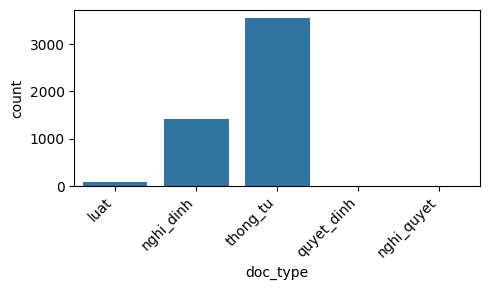

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(data=data, x='doc_type', y='count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

### <a id='toc1_1_3_'></a>[Count relation type](#toc0_)

In [9]:
#Relabel the annotation

import re

for file in files:
    file_path = os.path.join(train_path, file)

    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()

    content = re.sub(r'rel="CC"', 'rel="Pursuant"', content)
    content = re.sub(r'rel="DSD"', 'rel="Amended"', content)
    # content = re.sub(r'rel="HHL"', 'rel="Replaces"', content)
    content = re.sub(r'rel="Replaces"', 'rel="Drop"', content)
    content = re.sub(r'rel="DHD"', 'rel="Guide"', content)
    content = re.sub(r'rel="DaC"', 'rel="Reference"', content)
    content = re.sub(r'rel="BTT1"', 'rel="PartReplace"', content)
    content = re.sub(r'rel="BTT"', 'rel="Replace"', content)
    content = re.sub(r'rel="HHL1"', 'rel="PartDrop"', content)
    content = re.sub(r'rel="none"', 'rel="Others"', content)
    
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(content)

In [10]:
from collections import defaultdict

rel_counts = defaultdict(int)

for file in files:
    file_path = os.path.join(train_path, file)

    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()

    # Find all occurrences of rel="x"
    matches = re.findall(r'rel="(.*?)"', content)

    for rel in matches:
        rel_counts[rel] += 1

print("Relation counts:")
for rel, count in rel_counts.items():
    print(f"{rel}: {count}")

Relation counts:
Pursuant: 18377
Reference: 27502
PartReplace: 218
PartDrop: 480
Others: 9858
Amended: 1359
Replace: 1533
Drop: 993
Guide: 368


In [17]:
rel = pd.DataFrame.from_dict(rel_counts, orient='index', columns=['count']).reset_index().rename(columns={'index': 'relation'})

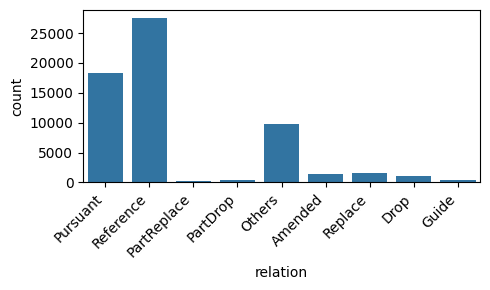

In [35]:
plt.figure(figsize=(5, 3))
sns.barplot(data=rel, x='relation', y='count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


### <a id='toc1_1_4_'></a>[Some files with examples of each relation type](#toc0_)

In [36]:
import csv

# Initialize dictionary: relation → set of filenames
rel_files = defaultdict(set)

# Loop through all files
for file in files:
    file_path = os.path.join(train_path, file)

    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()

    # Find all relation tags (rel="SOMETHING")
    matches = re.findall(r'rel="(.*?)"', content)

    for rel in matches:
        rel_files[rel].add(file)

# Print a readable summary
for rel, file_set in rel_files.items():
    print(f"\nRelation: {rel} (appears in {len(file_set)} files)")
    print("Example files:", list(file_set)[:10])  # show first 10 examples

# --- Optional: Save to CSV ---
output_csv = os.path.join(train_path, "relation_file_map.csv")

with open(output_csv, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Relation", "Num_Files", "File_List"])
    for rel, file_set in rel_files.items():
        writer.writerow([rel, len(file_set), "; ".join(sorted(file_set))])

print(f"\n✅ Saved relation–file mapping to: {output_csv}")



Relation: Pursuant (appears in 4788 files)
Example files: ['6815.xml', '8534.xml', '6351.xml', '5432.xml', '2406.xml', '8539.xml', '11775.xml', '4332.xml', '6754.xml', '11457.xml']

Relation: Reference (appears in 3265 files)
Example files: ['6815.xml', '8534.xml', '6351.xml', '5432.xml', '2406.xml', '8539.xml', '11775.xml', '6754.xml', '11457.xml', '2713.xml']

Relation: PartReplace (appears in 148 files)
Example files: ['8247.xml', '11337.xml', '9600.xml', '5326.xml', '9668.xml', '12129.xml', '12697.xml', '5621.xml', '9384.xml', '11323.xml']

Relation: PartDrop (appears in 352 files)
Example files: ['2476.xml', '2406.xml', '4332.xml', '5492.xml', '7537.xml', '12053.xml', '3462.xml', '4640.xml', '3772.xml', '9459.xml']

Relation: Others (appears in 3319 files)
Example files: ['6815.xml', '8534.xml', '2406.xml', '8539.xml', '11775.xml', '4332.xml', '6754.xml', '11457.xml', '2713.xml', '7537.xml']

Relation: Amended (appears in 665 files)
Example files: ['11486.xml', '6232.xml', '11599

### <a id='toc1_1_5_'></a>[Extraction of X, y and save to Ggsheet for annotation](#toc0_)

In [62]:
def extract_relation_sentences(train_path):
    rel_pattern = re.compile(r'rel="([^"]+)"')
    tag_pattern = re.compile(r'<[^>]+>')
    inner_pattern = re.compile(r'<[^>]+>(.*?)</[^>]+>')

    # document name patterns
    doc_pattern = r'(Luật|Bộ[_\s]*Luật|Pháp[_\s]*lệnh|Nghị[_\s]*định|Quyết[_\s]*định|Thông[_\s]*tư|Nghị[_\s]*quyết)'
    intra_pattern = (
        r'(Điều|Chương|Mục|Phần|khoản|điểm)\s*\d+((?:\s|,|\s*và\s*)'
        r'(khoản|Điều|mục|điểm|Chương)\s*\d+)*'
    )

    def normalize_whitespace(text):
        text = re.sub(r'\s+([,.;:?!])', r'\1', text)
        text = re.sub(r'([,.;:?!])(?=\w)', r'\1 ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\s*_\s*', '_', text)
        return text.strip()

    data = []
    files = [f for f in os.listdir(train_path) if f.endswith(".xml")]

    for file in files:
        file_path = os.path.join(train_path, file)
        with open(file_path, "r", encoding="utf-8") as fh:
            # skip first 2 lines (adjust if needed)
            for _ in range(2):
                next(fh, None)
            content = fh.read()

        # Get sentences using sent_tokenize and ensure non-empty
        sentences = sent_tokenize(content)
        if not sentences:
            continue

        # --- Process the FIRST sentence separately: split it into subsentences
        first_sent = sentences[0]
        first_subs = [s.strip() for s in re.split(r'(?<=[.;])\s+', first_sent) if s.strip()]

        for sub in first_subs:
            if 'rel="' not in sub:
                continue
            rels = rel_pattern.findall(sub)
            entities = inner_pattern.findall(sub)
            clean_text = tag_pattern.sub('', sub).strip()
            clean_text = normalize_whitespace(clean_text)

            for rel, entity in zip(rels, entities):
                pattern = re.compile(
                    rf'({intra_pattern}[^.]*?của\s+{doc_pattern}[^;.]*)',
                    re.IGNORECASE
                )
                match = pattern.search(clean_text)
                if match:
                    entity_full = match.group(1).strip()
                else:
                    entity_full = normalize_whitespace(entity.strip())

                data.append({
                    "input_text": clean_text,
                    "first_entity": "self",   # mark self for subs from first sentence
                    "relation": rel,
                    "second_entity": entity_full,
                    "source_file": file
                })

        # --- Process remaining sentences: split each by . or ; into subs, but keep first_entity = None
        for sent in sentences[1:]:
            subs = [s.strip() for s in re.split(r'(?<=[.;])\s+', sent) if s.strip()]
            for sub in subs:
                if 'rel="' not in sub:
                    continue
                rels = rel_pattern.findall(sub)
                entities = inner_pattern.findall(sub)
                clean_text = tag_pattern.sub('', sub).strip()
                clean_text = normalize_whitespace(clean_text)

                for rel, entity in zip(rels, entities):
                    pattern = re.compile(
                        rf'({intra_pattern}[^.]*?của\s+{doc_pattern}[^;.]*)',
                        re.IGNORECASE
                    )
                    match = pattern.search(clean_text)
                    if match:
                        entity_full = match.group(1).strip()
                    else:
                        entity_full = normalize_whitespace(entity.strip())

                    data.append({
                        "input_text": clean_text,
                        "first_entity": None,   # not from first sentence
                        "relation": rel,
                        "second_entity": entity_full,
                        "source_file": file
                    })

    # Convert to DataFrame and normalize source_file
    df = pd.DataFrame(data)
    if df.empty:
        return df
    df['source_file'] = df['source_file'].replace(r'\.xml', '', regex=True).astype(int)

    # Final check 1: keep "self" only for texts starting with "Căn_cứ" (exact underscore)
    df.loc[df['first_entity'].eq('self') & ~df['input_text'].str.startswith('Căn_cứ'), 'first_entity'] = None

    # Final check 2: remove "self" if relation == "Others" (case-insensitive)
    df.loc[(df['relation'].str.lower() == 'others') & (df['first_entity'] == 'self'), 'first_entity'] = None

    return df

data = extract_relation_sentences(train_path)

df = pd.DataFrame(data)

df['source_file'] = df['source_file'].replace(r'\.xml', '', regex=True).astype(int)

In [64]:
write_df_to_gs(df, 'RE_training')

'New tab created and DataFrame written to Google Sheet: RE_training'

In [7]:
df['relation'].value_counts()

relation
Reference      27359
Pursuant       18345
Others          8440
Replace         1533
Amended         1356
Drop             993
PartDrop         480
Guide            365
PartReplace      218
Name: count, dtype: int64

#### Temporary fill non-self entity with non-self

In [2]:
training = gs_to_df_pandas('RE_training')

training['source_file'] = training['source_file'].astype(str)

In [7]:
training

,input_text,first_entity,relation,second_entity,source_file
0,Căn_cứ Hiến_pháp nước Cộng_hòa xã_hội chủ_nghĩ...,self,Pursuant,Hiến_pháp nước Cộng_hòa xã_hội chủ_nghĩa Việt_Nam,63
1,g ) Người đi làm_việc ở nước_ngoài theo hợp_đồ...,,Reference,Luật người lao_động Việt_Nam đi làm_việc ở nướ...,63
2,d ) Khởi_kiện ra Tòa_án đối_với hành_vi vi_phạ...,,Reference,khoản 8 Điều 10 của Luật công_đoàn,63
3,Người lao_động quy_định tại điểm đ và điểm e k...,,Reference,khoản 1 Điều 2 của Luật này nghỉ_việc có đủ 20...,63
4,Người lao_động quy_định tại điểm đ và điểm e k...,,Reference,khoản 1 Điều 2 của Luật này nghỉ_việc có đủ 20...,63
...,...,...,...,...,...
59074,phương_tiện nổi và các thiết_bị bảo_đảm an_toà...,,Others,Luật Quản_lý thuế,13870
59075,Thông_tư này có hiệu_lực thi_hành sau 15 ngày ...,,Replace,Thông_tư số 14/2004/TT-BTC ngày 8/3/2004,13870
59076,"Các nội_dung khác liên_quan đến việc thu, nộp,...",,Reference,Thông_tư số 63/2002/TT-BTC ngày 24/7/2002,13870
59077,"Các nội_dung khác liên_quan đến việc thu, nộp,...",,Reference,Thông_tư số 45/2006/TT-BTC ngày 25/5/2006,13870


In [11]:
training['first_entity'] = training['first_entity'].replace('', 'non_self')

In [12]:
training

,input_text,first_entity,relation,second_entity,source_file
0,Căn_cứ Hiến_pháp nước Cộng_hòa xã_hội chủ_nghĩ...,self,Pursuant,Hiến_pháp nước Cộng_hòa xã_hội chủ_nghĩa Việt_Nam,63
1,g ) Người đi làm_việc ở nước_ngoài theo hợp_đồ...,non_self,Reference,Luật người lao_động Việt_Nam đi làm_việc ở nướ...,63
2,d ) Khởi_kiện ra Tòa_án đối_với hành_vi vi_phạ...,non_self,Reference,khoản 8 Điều 10 của Luật công_đoàn,63
3,Người lao_động quy_định tại điểm đ và điểm e k...,non_self,Reference,khoản 1 Điều 2 của Luật này nghỉ_việc có đủ 20...,63
4,Người lao_động quy_định tại điểm đ và điểm e k...,non_self,Reference,khoản 1 Điều 2 của Luật này nghỉ_việc có đủ 20...,63
...,...,...,...,...,...
59074,phương_tiện nổi và các thiết_bị bảo_đảm an_toà...,non_self,Others,Luật Quản_lý thuế,13870
59075,Thông_tư này có hiệu_lực thi_hành sau 15 ngày ...,non_self,Replace,Thông_tư số 14/2004/TT-BTC ngày 8/3/2004,13870
59076,"Các nội_dung khác liên_quan đến việc thu, nộp,...",non_self,Reference,Thông_tư số 63/2002/TT-BTC ngày 24/7/2002,13870
59077,"Các nội_dung khác liên_quan đến việc thu, nộp,...",non_self,Reference,Thông_tư số 45/2006/TT-BTC ngày 25/5/2006,13870


In [13]:
write_df_to_gs(training, 'RE_training')

'New tab created and DataFrame written to Google Sheet: RE_training'